In [21]:
import os
import cv2
import numpy as np
import torch
import yaml
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn
import pandas as pd
import random
import torch.nn.functional as F
import torchvision.transforms.functional as tF

In [22]:
class PadToSquare:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img):
        # img: PIL Image or Tensor (C, H, W)
        if hasattr(img, "size"):  # PIL
            w, h = img.size
        else:  # Tensor
            _, h, w = img.shape

        max_side = max(h, w)
        pad_h = max_side - h
        pad_w = max_side - w

        padding = (
            pad_w // 2,
            pad_h // 2,
            pad_w - pad_w // 2,
            pad_h - pad_h // 2,
        )

        return T.functional.pad(img, padding, fill=self.fill)


In [23]:
class CenterCropRelative:
    def __init__(self, crop_pixels: int):
        self.crop_pixels = crop_pixels

    def __call__(self, img):
        # PIL: img.size -> (W, H)
        # Tensor: img.shape -> (C, H, W)
        if hasattr(img, "size"):
            w, h = img.size
        else:
            _, h, w = img.shape

        new_h = max(1, h - self.crop_pixels)
        new_w = max(1, w - self.crop_pixels)

        return tF.center_crop(img, [new_h, new_w])

In [24]:
def video_to_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)       # Compute indices of frames to extract
    frames = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)   # Jump directly to the frame
        ret, frame = cap.read()
        if not ret:
            continue

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR -> RGB
        frame = Image.fromarray(frame)
        frames.append(frame)

    cap.release()
    return frames


In [25]:
transform = T.Compose([
    PadToSquare(fill=0),
    CenterCropRelative(270),
    T.Resize((224, 224)),
    #T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], 
    #    std=[0.229, 0.224, 0.225]),
])

seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [26]:
class ImageBagDataset(Dataset):
    def __init__(self, 
                 root_dir: str,
                 annotations_file: str,
                 transform,
                 #holsbeke_histo = [['endometrioma', 'cystadenoma-fibroma', 'fibroma'], ['epithelial_invasive']],
                 holsbeke_histo = [['dermoid', 'serous_cystadenoma'], ['endometrioid_adenocarcinoma', 'high_grade_serous_adenocarcinoma', 'adenocarcinoma', 'clear_cell_carcinoma']],
                 with_frames: bool = False, 
                 numb_frames: int = 16, 
                 ) -> None:
        self.root_dir = root_dir
        self.bags = []
        clinical_table = pd.read_parquet(annotations_file)
        #img_labels = dict(zip(clinical_table['clinical_case'], clinical_table['holsbeke_histological']))
        img_labels = dict(zip(clinical_table['clinical_case'], clinical_table['histological']))
        considered_histo = set([h for group in holsbeke_histo for h in group])
        self.histo_dict = {k:v for k, v in img_labels.items() if v in considered_histo}

        for bag in os.scandir(root_dir):
            if bag.name in self.histo_dict.keys():
                num_videos = 0
                bag_path = os.path.join(root_dir, bag.name)
                for item in os.scandir(bag_path):
                    in_item_path = os.path.join(bag_path, item.name)
                    for in_item in os.scandir(in_item_path):
                        if in_item.name.endswith(".mp4"):
                            num_videos+=1
                if with_frames or num_videos<len(sorted(os.listdir(bag_path))):
                    self.bags.append(bag.name)
        
        self.labels_dict = {
            subtype: i
            for i, group in enumerate(holsbeke_histo)
            for subtype in group
        }
        self.risk_dict = {
            0: "benign", 
            1: "malignant"
        }
        self.transform = transform
        self.with_frames = with_frames
        self.numb_frames = numb_frames

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag_name = self.bags[idx]
        bag_path = os.path.join(self.root_dir, bag_name)

        instances = []
        for entry in os.scandir(bag_path):
            item_folder_path = os.path.join(bag_path, entry.name)
            for item_entry in os.scandir(item_folder_path):

                if item_entry.name.startswith(entry.name) and (item_entry.name.endswith(('.jpeg', '.png'))):    #if entry is an image file
                    img = Image.open(os.path.join(bag_path, item_entry)).convert("RGB")
                    instances.append(self.transform(img))

                if item_entry.name.endswith('.mp4') and self.with_frames:    #if entry is a video file
                    frames = video_to_frames(item_entry.path, self.numb_frames)
                    for frame in frames:
                        instances.append(self.transform(frame))

        #instances = torch.stack(instances)  # (bag_size, 3, 224, 224)
        bag_label = self.labels_dict[self.histo_dict[bag_name]]

        return instances, bag_name, bag_label


In [27]:
#features_path = "C:\\Users\\utente\\Documents\\UNI\\MAGISTRALE\\tesi\\raw_dataset\\artifacts\\embeddings\\features"
#labels_path = "C:\\Users\\utente\\Documents\\UNI\\MAGISTRALE\\tesi\\raw_dataset\\artifacts\\embeddings\\labels"
#root_dir = "C:\\Users\\utente\\Documents\\UNI\\MAGISTRALE\\tesi\\raw_dataset\\artifacts\\Dataset"
#annotations_file = "C:\\Users\\utente\\Documents\\UNI\\MAGISTRALE\\tesi\\raw_dataset\\artifacts\\clinical_case_metadata.parquet"
features_path = "/home/silvia.collicelli/project/embeddings/features"
labels_path = "/home/silvia.collicelli/project/embeddings/labels"
root_dir = "/home/silvia.collicelli/data/Dataset"
annotations_file = "/home/silvia.collicelli/data/controlled_dataset_metadata.parquet"


In [28]:
dataset = ImageBagDataset(root_dir, annotations_file, transform)

In [29]:
for i in range(10):
    print(dataset[i][0][0].size)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


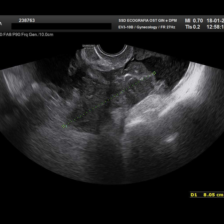

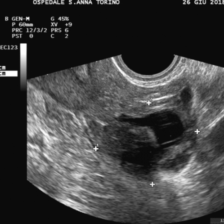

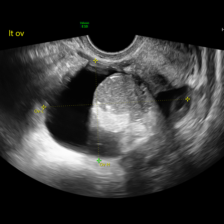

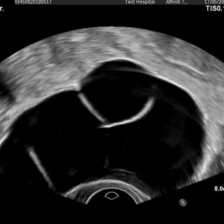

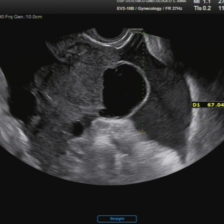

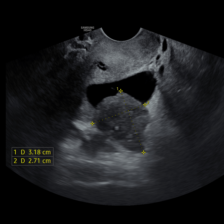

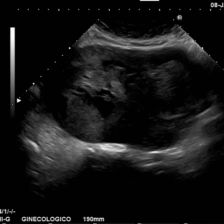

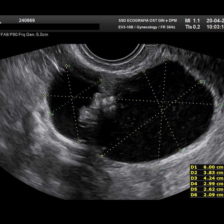

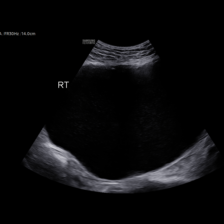

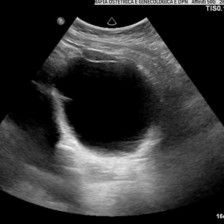

In [30]:
for i in range(10):
    display(dataset[i][0][0])